# Setup

## Environment Variables

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Imports and Constants

In [2]:
from pathlib import Path
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from PIL import Image
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.field_components.field_heads import FieldHeadNames
from diffusers import StableDiffusionImg2ImgPipeline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

config_path = "/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/config.yml"
config_path = Path("/", *config_path.split("/"))
checkpoint_path = "/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/nerfstudio_models"

fg_config_path = "/root/yairshp/output_models/transformations/outputs/ficus/mipnerf/2023-09-23_212151/config.yml"
fg_config_path = Path("/", *fg_config_path.split("/"))
fg_checkpoint_path = "/root/yairshp/output_models/transformations/outputs/ficus/mipnerf/2023-09-23_212151/nerfstudio_models"

## Loading Models and Data

### NeRF Models

In [4]:
_, pipeline, _, _ = eval_setup(config_path, eval_num_rays_per_chunk=None, test_mode="inference", checkpoint_path=checkpoint_path)
_, fg_pipeline, _, _ = eval_setup(fg_config_path, eval_num_rays_per_chunk=None, test_mode="inference", checkpoint_path=fg_checkpoint_path)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/nerfstudio_models/step-000999999.ckp
t

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/root/yairshp/output_models/transformations/outputs/ficus/mipnerf/2023-09-23_212151/nerfstudio_models/step-000999999.ckp
t

In [5]:
pipeline.datamanager.setup_train()
fg_pipeline.datamanager.setup_train()
num_of_viewpoints = len(pipeline.datamanager.train_dataset)
dataloader = DataLoader(np.array([i for i in range(num_of_viewpoints)]), batch_size=None, shuffle=True, num_workers=4)

Setting up training dataset...

Caching all 120 images.

Output()

Setting up training dataset...

Caching all 100 images.

Output()

### Diffusion Model

In [6]:
model_id = "stabilityai/stable-diffusion-2-base"
diffusion_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Optimization

In [7]:
class TransformationsLearner(nn.Module):
    '''
    fg_init_transforamtions is a dict containing the following keys:
    1. translation: 3d vector defining the position of the object in the space
    2. scale: scalar defining the zoom in/out of the object
    3. rotation_x: scalar defining the angle (in radians) of the x axis rotation
    4. rotation_y: scalar defining the angle (in radians) of the y axis rotation
    5. rotation_z: scalar defining the angle (in radians) of the z axis rotation
    '''
    def __init__(self, bg_pipeline, fg_pipeline, fg_init_transformations=None):
        super().__init__()
        self.bg_pipeline = bg_pipeline
        for p in self.bg_pipeline.model.parameters():
            p.requires_grad = False
        self.fg_pipeline = fg_pipeline
        for p in self.fg_pipeline.model.parameters():
            p.requires_grad = False

        if fg_init_transformations is None:
            fg_init_transformations = self._create_default_fg_init_transformations()
        
        # self.rotation_x = nn.Parameter(torch.tensor(fg_init_transformations['rotation_x']))
        # self.rotation_y = nn.Parameter(torch.tensor(fg_init_transformations['rotation_y']))
        self.rotation_z = nn.Parameter(torch.tensor(fg_init_transformations['rotation_z']))

        self.translation = fg_init_transformations['translation']
        self.scale = fg_init_transformations['scale']

    def forward(self, x):
        '''
        input: the viewpoint represented as a scalar tensor, which is an index in the BG NeRF train dataset
        output: rendered image of the fg object on the bg scene
        '''
        # create bg ray bundle
        camera_transforms = self.bg_pipeline.datamanager.train_camera_optimizer(x.unsqueeze(dim=0))
        current_camera = self.bg_pipeline.datamanager.train_dataparser_outputs.cameras[x].to(device)
        # change the current camera to fit 512x512 resolution
        current_camera = Cameras(
            fx=torch.tensor([[548.9938],[548.9938]]).to(device),
            fy=torch.tensor([[548.9938],[548.9938]]).to(device),
            cx=torch.tensor(256.).to(device),
            cy=torch.tensor(256.).to(device),
            camera_to_worlds=current_camera.camera_to_worlds,
            camera_type=current_camera.camera_type,
            times=current_camera.times
        )
        bg_ray_bundle = current_camera.generate_rays(torch.tensor(list(range(1))).unsqueeze(-1), camera_opt_to_camera=camera_transforms, aabb_box=None)

        # create fg transforamtion matrix
        translation_matrix = self._create_translation_matrix()
        scale_matrix = self._create_scale_matrix()
        rotation_x_matrix = self._create_rotation_x_matrix()
        rotation_y_matrix = self._create_rotation_y_matrix()
        rotation_z_matrix = self._create_rotation_z_matrix()
        full_transformations_matrix = self._create_full_transformations_matrix(
            translation_matrix=translation_matrix,
            scale_matrix=scale_matrix,
            rotation_x_matrix=rotation_x_matrix,
            rotation_y_matrix=rotation_y_matrix,
            rotation_z_matrix=rotation_z_matrix,
        ).to(device)

        # create fg ray bundle
        dummy_vector = torch.tensor([[0., 0., 0., 1.]], device=device)
        extended_tranformations_matrix = torch.cat((full_transformations_matrix, dummy_vector), dim=0)
        extended_c2w = torch.cat((current_camera.camera_to_worlds[0], dummy_vector), dim=0)
        transformed_camera = Cameras(
            camera_to_worlds=torch.stack(
                (
                    (extended_tranformations_matrix @ extended_c2w)[:3], 
                    (extended_tranformations_matrix @ extended_c2w)[:3]
                ), 
                dim=0), 
                fx=current_camera.fx,
                fy=current_camera.fy,
                cx=current_camera.cx,
                cy=current_camera.cy,
                times=current_camera.times 
        )
        fg_ray_bundle = transformed_camera.generate_rays(
            torch.tensor(list(range(1))).unsqueeze(-1), 
            camera_opt_to_camera=full_transformations_matrix, 
            aabb_box=None
        )

        # render bg + fg
        outputs = self.bg_pipeline.model.get_outputs_for_camera_ray_bundle(
            bg_ray_bundle, 
            fg_pipeline=self.fg_pipeline,
            fg_camera_ray_bundle=fg_ray_bundle,
        )        

        return outputs['rgb_coarse']

    def _create_default_fg_init_transformations(self):
        return {
            'translation': torch.tensor([0., 0., 0.]),
            'scale': torch.tensor(1),
            'rotation_x': torch.tensor(0),
            'rotation_y': torch.tensor(0),
            'rotation_z': torch.tensor(0),
        }
    def _create_translation_matrix(self):
        return torch.tensor([
            [1., 0., 0., self.translation[0]],
            [0., 1., 0., self.translation[1]],
            [0., 0., 1., self.translation[2]],
            [0., 0., 0., 1.],
        ])

    def _create_scale_matrix(self):
        return torch.tensor([
            [self.scale, 0., 0., 0.],
            [0., self.scale, 0., 0.],
            [0., 0., self.scale, 0.],
            [0., 0., 0., 1.],
        ])

    def _create_rotation_x_matrix(self):
        return torch.diag(torch.tensor([1., 1., 1., 1.,]))

    def _create_rotation_y_matrix(self):
        return torch.diag(torch.tensor([1., 1., 1., 1.,]))

    def _create_rotation_z_matrix(self):
        return torch.tensor([
            [torch.cos(self.rotation_z), torch.sin(self.rotation_z), 0., 0.],
            [-torch.sin(self.rotation_z), torch.cos(self.rotation_z), 0., 0.],
            [0., 0., 1., 0.],
            [0., 0., 0., 1.]
        ])

    def _create_full_transformations_matrix(self, 
                                            translation_matrix, 
                                            scale_matrix, 
                                            rotation_x_matrix, 
                                            rotation_y_matrix, 
                                            rotation_z_matrix
                                            ):
        return (rotation_z_matrix @ rotation_y_matrix @ rotation_x_matrix @ scale_matrix @ translation_matrix)[:-1, :]


In [8]:
fg_init_transformations = {
    'translation': torch.tensor([-0.5, 0., -1.53]),
    'scale': torch.tensor(1.1),
    'rotation_z': math.pi / 4,
}

In [9]:
model = TransformationsLearner(bg_pipeline=pipeline, fg_pipeline=fg_pipeline, fg_init_transformations=fg_init_transformations)
optimizer = Adam(model.parameters(), lr=1e-4)

In [10]:
def reconstruct_img(pipe, img, caption, strength=0.4, guidance_scale=5):
    images = pipe(
        prompt=caption,
        image=img,
        strength=strength,
        guidance_scale=guidance_scale,
        generator=torch.Generator().manual_seed(0),
    ).images
    return images[0]

def calculate_mse(original_img, reconstructed_img, bboxes=None):
    original_img = transforms.ToTensor()(original_img)
    reconstructed_img = transforms.ToTensor()(reconstructed_img)
    if bboxes is not None:
        mask = torch.zeros_like(original_img[0])
        for bbox in bboxes:
            mask[bbox[1].int().item():bbox[3].int().item(), bbox[0].int().item():bbox[2].int().item()] = 1
        mask = mask.unsqueeze(0)
        original_img = original_img * mask
        reconstructed_img = reconstructed_img * mask
    return torch.nn.functional.mse_loss(original_img, reconstructed_img).item()

In [18]:
criterion = torch.nn.MSELoss()
for i, idx in enumerate(dataloader):
    rendered = model(idx)
    # print(rendered.shape)
    rendered = torch.permute(rendered, (2, 0, 1))
    reconstructed = reconstruct_img(diffusion_pipe, rendered, 'vase on table', strength=0.5)
    transform = transforms.Compose([transforms.PILToTensor()])
    reconstructed = transform(reconstructed).to(device)
    # print(reconstructed.shape, rendered.shape)
    loss = criterion(rendered, reconstructed)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"{i + 1}: {loss.item()}")

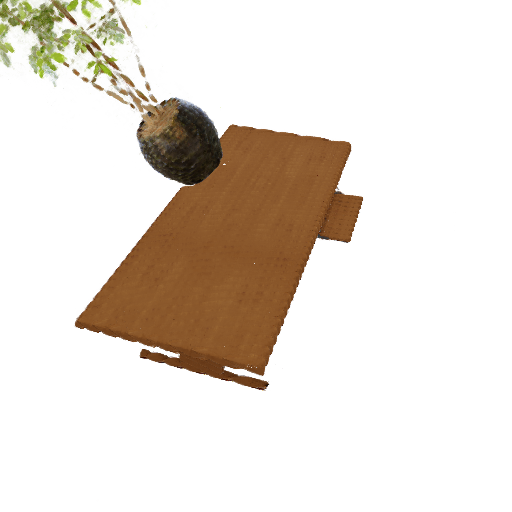

In [ ]:
image = (rendered.cpu().numpy() * 255).astype(np.uint8)
image = Image.fromarray(image)
image